
# models and dataloaders

In [8]:
from acevedo_clss_and_fcns import * 
from sklearn.metrics import roc_curve, auc

device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")

from graph_tool import *
from graph_tool.draw import * 
import matplotlib
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
def get_nx_G_and_export_graphml(edge_weights, graphml_path: str):
    
    edge_list = []
    for i, r in edge_weights[["node1","node2"]].iterrows():
        edge_list.append((r[0],r[1]))        
    G = nx.Graph()
    G.add_edges_from(edge_list)  
    scaler = MinMaxScaler(feature_range=(1, 10))
    weights = list(scaler.fit_transform(
        np.array(edge_weights.select_dtypes(include=np.number).sum(axis=1)).reshape(-1, 1)).squeeze()
    )
    w  = dict(zip(G.edges() , weights))
    nx.set_edge_attributes(G, w, "weights")
    nx.write_graphml(G, graphml_path)
    return copy.deepcopy(G)

def export_visualization(graphml_path = "./results/graphs/Non_masked_edge_weights.graphml",
                         output_path  =  "./results/figures/Non_masked_weights_graph.png"):
    
    GT    = load_graph(graphml_path)
    pos = sfdp_layout(GT,  C=1,p=2,  theta= .005, r = 9, K = 3)
    graph_draw(GT, pos = pos, #bg_color = 'white', 
            output = output_path,
            edge_pen_width = GT._Graph__edge_properties.weights, 
            edge_color= GT._Graph__edge_properties.weights, vertex_size= 8,
            adjust_aspect = True, fit_view_ink = True,
            vcmap= (matplotlib.cm.PuBu, 1  ),
            ecmap= (matplotlib.cm.Blues, .8), elen = 5, output_size = (500, 500))
model_masked      = torch.load("./results/trained_models/Masked_Phe/Model_GIN_classifier_to_explain_v2_16-11-2022_16h_40min_best_ValAcc_0.8775340183282422_epoch_28.pt")
loader_masked     = torch.load("./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt").get_test_loader()
model_NON_Masked  = torch.load("./results/trained_models/Non_masked_Phe/Model_GIN_classifier_to_explain_v2_16-11-2022_16h_37min_best_ValAcc_0.9938905859483477_epoch_9.pt")
loader_NON_Masked = torch.load("./results/dataloaders/loader_Concen_plus_Fluxes.pt").get_test_loader()
edge_weights_Non_masked = pd.read_parquet("./results/dataframes/Non_masked_edges_node_names_explainer_subgraphs.parquet.gzip").reset_index(drop=True)
edge_weights_Masked     = pd.read_parquet("./results/dataframes/Masked_edges_node_names_explainer_subgraphs.parquet.gzip").reset_index(drop=True)

learning_curves_MASKED     = pd.read_csv("./results/dataframes/learning_curves_MASKED.csv")
learning_curves_NON_masked = pd.read_csv("./results/dataframes/learning_curves_NON_masked.csv")

all_train_accuracy_Unmasked       = learning_curves_NON_masked['train_accuracy']
all_validation_accuracy_Unmasked  = learning_curves_NON_masked['validation_accuracy']




all_train_accuracy_MASKED          = learning_curves_MASKED['train_accuracy']
all_validation_accuracy_MASKED     = learning_curves_MASKED['validation_accuracy']

device = 'cuda:0'


In [3]:
from sklearn.metrics import roc_curve, auc



def get_ROC_parameters(model, test_loader):

    tprs            = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    for i, test_data in enumerate(test_loader):
            
        assert not test_data.is_cuda
        if (device == 'cuda:0') | (device == 'cuda'):
            test_data.to(device, non_blocking=True) 
            assert test_data.is_cuda                          

        test_predictions = model(test_data.x, test_data.edge_index,  test_data.batch)# Make predictions for this batch
        pred            = test_predictions.argmax(dim=1)
        y_batch         = test_data.y
        
        y_pred_tag = pred.squeeze().cpu().int().tolist()
        y_true     = y_batch.squeeze().cpu().int().tolist()
        fpr, tpr, _ = roc_curve(y_true, y_pred_tag)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)


    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)


    tprs_upper = np.minimum(mean_tprs + tprs.std(axis=0), 1)
    tprs_lower = mean_tprs - tprs.std(axis=0)
    
    return base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc

def put_ROC_in_subplot(base_fpr, mean_tprs, tprs_lower,
                   tprs_upper, mean_auc, std_auc, AX, xlabel:str='', letter:str=''):
    
    AX.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Test set ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    AX.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
    AX.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Random', alpha= 0.8)

    #ax1.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])

    AX.legend(loc="lower right", fontsize=7.5)
    AX.set_ylabel('True Positive Rate')
    AX.set_xlabel(xlabel)
    AX.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')
    
    
def put_Learning_curve(all_train_accuracy, all_validation_accuracy, AX, letter):
    AX.plot(all_train_accuracy,  label = "Train set", linestyle="--")
    AX.plot(all_validation_accuracy,  label = "Validation set", linestyle="-")
    AX.legend(loc="lower right", fontsize=11)
    AX.set_ylabel('Accuracy (%)')
    AX.set_xlabel("Epochs")
    AX.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')




base_fpr_Unmasked, mean_tprs_Unmasked, tprs_lower_Unmasked, tprs_upper_Unmasked, mean_auc_Unmasked, std_auc_Unmasked = get_ROC_parameters(model_NON_Masked, loader_NON_Masked)
base_fpr_MASKED, mean_tprs_MASKED, tprs_lower_MASKED, tprs_upper_MASKED, mean_auc_MASKED, std_auc_MASKED = get_ROC_parameters(model_masked, loader_masked) 


       

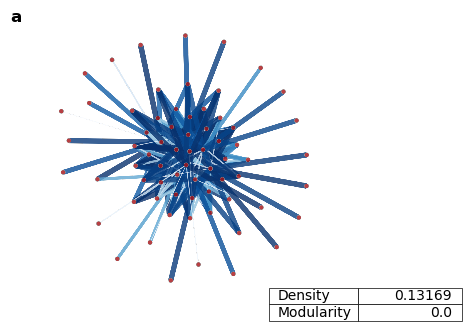

In [53]:
import networkx.algorithms.community as nx_comm



import matplotlib

NX_masked = get_nx_G_and_export_graphml(edge_weights_Masked,  "./results/graphs/Masked_edge_weights.graphml")    
export_visualization("./results/graphs/Masked_edge_weights.graphml",  "./results/figures/Masked_weights_graph.png")
    
NX_Non_masked = get_nx_G_and_export_graphml(edge_weights_Non_masked,  "./results/graphs/Non_masked_edge_weights.graphml")    
export_visualization("./results/graphs/Non_masked_edge_weights.graphml",  "./results/figures/Non_masked_weights_graph.png")



graph_NON_masked = matplotlib.image.imread( "./results/figures/Non_masked_weights_graph.png")
graph_masked     = matplotlib.image.imread( "./results/figures/Masked_weights_graph.png")

NON_masked_modularity = nx_comm.modularity(NX_Non_masked, nx_comm.label_propagation_communities(NX_Non_masked)) 
NON_masked_density    =  nx.density(NX_Non_masked)

masked_modularity     = nx_comm.modularity(NX_masked, nx_comm.label_propagation_communities(NX_masked)) 
masked_density        = nx.density(NX_masked)

plt.style.use('ggplot')   



fig = plt.figure(figsize=(4,7))
#ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 1), (1, 0), colspan=1)

def place_image(im, ax=None, zoom=1, letter='', Density=np.nan, Modularity=np.nan, table_pos = ''):
    if ax==None: ax=plt.gca()
    imagebox = OffsetImage(im, zoom=zoom)
    ab       = AnchoredOffsetbox(loc='center', child=imagebox, pad=0., borderpad =0, frameon=False)
    ax.add_artist(ab)
    ax.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')

    row_labels=['Density','Modularity']
    table_vals=[[np.round(Density,5)], [np.round(Modularity,5)]]
# the rectangle is where I want to place the table
    the_table = ax.table(cellText=table_vals,
                  colWidths = [.3,1], 
                  rowLabels=row_labels,
                  
                  #colLabels=col_labels,
                  loc=table_pos)
    the_table.auto_set_font_size(True)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.axis('off')
    #ax.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')
    #the_table.set_fontsize(14)

    


place_image(graph_masked,letter = 'a', ax=ax2,zoom=0.2,Density=masked_density, Modularity=masked_modularity, table_pos = 'bottom right')

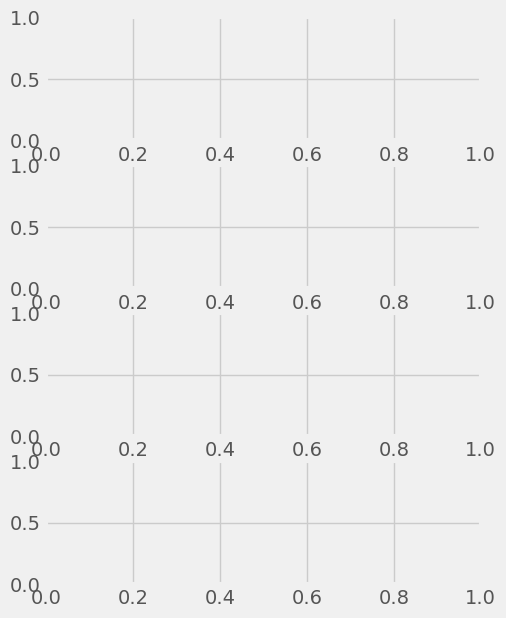

In [49]:
from graph_tool import *
from graph_tool.draw import * 
import matplotlib
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
def get_nx_G_and_export_graphml(edge_weights, graphml_path: str):
    
    edge_list = []
    for i, r in edge_weights[["node1","node2"]].iterrows():
        edge_list.append((r[0],r[1]))        
    G = nx.Graph()
    G.add_edges_from(edge_list)  
    scaler = MinMaxScaler(feature_range=(1, 10))
    weights = list(scaler.fit_transform(
        np.array(edge_weights.select_dtypes(include=np.number).sum(axis=1)).reshape(-1, 1)).squeeze()
    )
    w  = dict(zip(G.edges() , weights))
    nx.set_edge_attributes(G, w, "weights")
    nx.write_graphml(G, graphml_path)
    return copy.deepcopy(G)

def export_visualization(graphml_path = "./results/graphs/Non_masked_edge_weights.graphml",
                         output_path  =  "./results/figures/Non_masked_weights_graph.png"):
    
    GT    = load_graph(graphml_path)
    pos = sfdp_layout(GT,  C=1,p=2,  theta= .005, r = 9, K = 3)
    graph_draw(GT, pos = pos, #bg_color = 'white', 
            output = output_path,
            edge_pen_width = GT._Graph__edge_properties.weights, 
            edge_color= GT._Graph__edge_properties.weights, vertex_size= 8,
            adjust_aspect = True, fit_view_ink = True,
            vcmap= (matplotlib.cm.PuBu, 1  ),
            ecmap= (matplotlib.cm.Blues, .8), elen = 5, output_size = (500, 500))
    
NX_masked = get_nx_G_and_export_graphml(edge_weights_Masked,  "./results/graphs/Masked_edge_weights.graphml")    
export_visualization("./results/graphs/Masked_edge_weights.graphml",  "./results/figures/Masked_weights_graph.png")
    
NX_Non_masked = get_nx_G_and_export_graphml(edge_weights_Non_masked,  "./results/graphs/Non_masked_edge_weights.graphml")    
export_visualization("./results/graphs/Non_masked_edge_weights.graphml",  "./results/figures/Non_masked_weights_graph.png")






def get_degree_sequence(G):
    

    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    #dmax = max(degree_sequence)
    #fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    #axgrid = fig.add_gridspec(5, 4)
    #degree_counts = np.unique(degree_sequence, return_counts=True)
    return(degree_sequence)

plt.style.use('fivethirtyeight')   
fig = plt.figure(figsize=(5,7))
ax1 = plt.subplot2grid((4, 1), (0, 0), colspan=1)
ax2 = plt.subplot2grid((4, 1), (1, 0), colspan=1)

ax3 = plt.subplot2grid((4, 1), (2, 0), colspan=1)
ax4 = plt.subplot2grid((4, 1), (3, 0), colspan=1)


#degree_counts = get_degree_distr(NX_edge_weights_Non_masked)
#ax1.bar(*degree_counts)
#ax1.set_yscale('log')







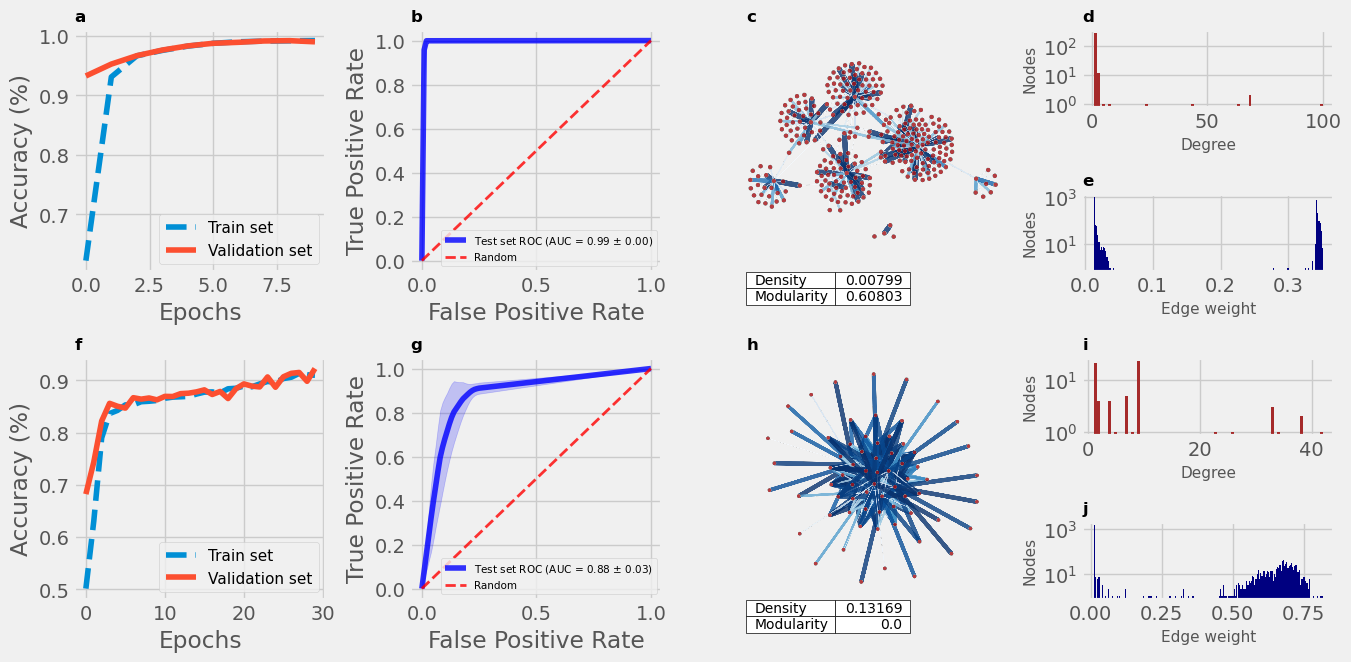

In [58]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')   
fig = plt.figure(figsize=(21,6))
ax0 = plt.subplot2grid((4, 8), (0, 0), rowspan=2 , colspan=2)
ax1 = plt.subplot2grid((4, 8), (0, 2), rowspan=2 ,colspan=2)
ax2 = plt.subplot2grid((4, 8), (0, 4), rowspan=2 ,colspan=2)

ax3 = plt.subplot2grid((4, 8), (0, 6), rowspan=1 ,colspan=2)
ax4 = plt.subplot2grid((4, 8), (1, 6), rowspan=1 ,colspan=2)

ax5 = plt.subplot2grid((4, 8), (2, 0), rowspan=2 , colspan=2)
ax6 = plt.subplot2grid((4, 8), (2, 2), rowspan=2 ,colspan=2)
ax7 = plt.subplot2grid((4, 8), (2, 4), rowspan=2 ,colspan=2)

ax8 = plt.subplot2grid((4, 8), (2, 6), rowspan=1 ,colspan=2)
ax9 = plt.subplot2grid((4, 8), (3, 6), rowspan=1 ,colspan=2)



plt.subplots_adjust(left=0.1, bottom=0.1, right=.7, top=1.05, wspace=1, hspace=1.1)    


put_Learning_curve(all_train_accuracy_Unmasked, all_validation_accuracy_Unmasked, ax0, 'a')
put_ROC_in_subplot(base_fpr_Unmasked, mean_tprs_Unmasked, tprs_lower_Unmasked, tprs_upper_Unmasked, mean_auc_Unmasked, std_auc_Unmasked,
                   ax1, xlabel = 'False Positive Rate', letter = 'b')


place_image(graph_NON_masked, letter='c' ,ax=ax2,zoom=0.2,Density=NON_masked_density, Modularity=NON_masked_modularity, table_pos = 'bottom')


put_Learning_curve(all_train_accuracy_MASKED, all_validation_accuracy_MASKED, ax5, 'f')
put_ROC_in_subplot(base_fpr_MASKED, mean_tprs_MASKED, tprs_lower_MASKED, tprs_upper_MASKED, mean_auc_MASKED, std_auc_MASKED,
                   ax6, xlabel = 'False Positive Rate', letter = 'g')



place_image(graph_masked,letter='h' ,ax=ax7,zoom=0.17,Density=masked_density, Modularity=masked_modularity, table_pos = 'bottom')



ax3.hist(get_degree_sequence(NX_Non_masked), bins=80, color='brown')
ax3.set_yscale('log')
ax3.set_title('d', fontsize = 12,  fontweight ="bold", loc='left')
ax3.set_xlabel('Degree',fontsize = 11)
ax3.set_ylabel('Nodes',fontsize = 11)


ax4.hist(edge_weights_Non_masked.select_dtypes(float).mean(), bins=200, color='navy')
ax4.set_yscale('log')
ax4.set_title('e', fontsize = 12,  fontweight ="bold", loc='left')
ax4.set_xlabel('Edge weight',fontsize = 11)
ax4.set_ylabel('Nodes',fontsize = 11)


ax8.hist(get_degree_sequence(NX_masked), bins=80, color='brown')
ax8.set_yscale('log')
ax8.set_title('i', fontsize = 12,  fontweight ="bold", loc='left')
ax8.set_xlabel('Degree',fontsize = 11)
ax8.set_ylabel('Nodes',fontsize = 11)

ax9.hist(edge_weights_Masked.select_dtypes(float).mean(), bins=200, color='navy')
ax9.set_yscale('log')
ax9.set_title('j', fontsize = 12,  fontweight ="bold", loc='left')
ax9.set_xlabel('Edge weight',fontsize = 11)
ax9.set_ylabel('Nodes',fontsize = 11)



plt.savefig("./results/figures/Figure_2.png",
            bbox_inches ="tight",
            pad_inches = 0.01,
            transparent = False)

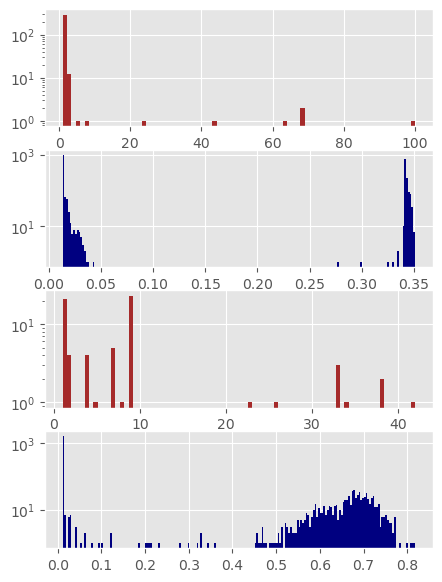

0.0

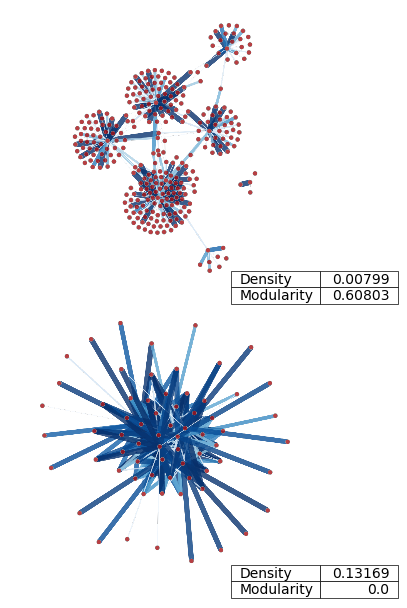

In [128]:
import networkx.algorithms.community as nx_comm
NON_masked_modularity = nx_comm.modularity(NX_Non_masked, nx_comm.label_propagation_communities(NX_Non_masked)) 
NON_masked_density    =  nx.density(NX_Non_masked)

masked_modularity     = nx_comm.modularity(NX_masked, nx_comm.label_propagation_communities(NX_masked)) 
masked_density        = nx.density(NX_masked)


graph_NON_masked = matplotlib.image.imread( "./results/figures/Non_masked_weights_graph.png")
graph_masked     = matplotlib.image.imread( "./results/figures/Masked_weights_graph.png")


plt.style.use('ggplot')   



fig = plt.figure(figsize=(4,7))
ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 1), (1, 0), colspan=1)

def place_image(im, ax=None, zoom=1, letter='', Density=np.nan, Modularity=np.nan, table_pos = ''):
    if ax==None: ax=plt.gca()
    imagebox = OffsetImage(im, zoom=zoom)
    ab       = AnchoredOffsetbox(loc='center', child=imagebox, pad=0., borderpad =0, frameon=False)
    ax.add_artist(ab)
    ax.set_title(letter, fontsize = 15,  fontweight ="bold", loc='left')

    row_labels=['Density','Modularity']
    table_vals=[[np.round(Density,5)], [np.round(Modularity,5)]]
# the rectangle is where I want to place the table
    the_table = ax.table(cellText=table_vals,
                  colWidths = [.25,.25], 
                  rowLabels=row_labels,
                  
                  #colLabels=col_labels,
                  loc=table_pos)
    the_table.auto_set_font_size(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.axis('off')
    #the_table.set_fontsize(14)

    
place_image(graph_NON_masked, ax=ax1,zoom=0.2,Density=NON_masked_density, Modularity=NON_masked_modularity, table_pos = 'bottom right')


place_image(graph_masked, ax=ax2,zoom=0.2,Density=masked_density, Modularity=masked_modularity, table_pos = 'bottom right')



masked_modularity



## Masked and Non-masked

In [1]:
def test_model(modelo: GIN_classifier_to_explain_v2, loader: DataLoader, device: str = 'cpu'):
    
    modelo.eval()
    all_predictions = []
    all_true        = []
    tprs            = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    #correct = 0
    for i, val_data in enumerate(loader):
        
        assert not val_data.is_cuda
        if (device == 'cuda:0') | (device == 'cuda'):
            val_data.to(device, non_blocking=True) 
            assert val_data.is_cuda                          

        val_predictions = modelo(val_data.x, val_data.edge_index,  val_data.batch)# Make predictions for this batch
        pred            = val_predictions.argmax(dim=1)
        
        fpr, tpr, _ = roc_curve(pred.cpu().tolist(),  val_data.y.cpu().tolist())
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        
        
        #all_predictions.extend(pred.cpu().tolist())
        #all_true.extend(val_data.y.cpu().tolist())

    return tprs #all_predictions, all_true    #correct += int((pred == val_data.y).sum())
        


def get_plot_data(tprs):
    base_fpr = np.linspace(0, 1, 101)
    aucs = []
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    return base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc




def get_plot_params(model, loader_validation):
    

    model.eval()

    tprs = test_model(model, loader_validation, device = 'cuda:0')



    return get_plot_data(tprs)

model_Masked_Phe            = torch.load(
                                    "./results/trained_models/Masked_Phe/Model_GIN_classifier_to_explain_v2_16-11-2022_16h_40min_best_ValAcc_0.8775340183282422_epoch_28.pt")

loader_validation_Masked_Phe = torch.load("./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt").get_validation_loader()



base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc = get_plot_params(model_Masked_Phe.to(device, non_blocking=True), loader_validation_Masked_Phe)



model_NON_Masked_Phe            = torch.load(
                                    "./results/trained_models/Non_masked_Phe/Model_GIN_classifier_to_explain_v2_16-11-2022_16h_37min_best_ValAcc_0.9938905859483477_epoch_9.pt")

loader_validation_NON_Masked_Phe = torch.load("./results/dataloaders/loader_Concen_plus_Fluxes.pt").get_validation_loader()


base_fpr_2, mean_tprs_2, tprs_lower_2, tprs_upper_2, mean_auc_2, std_auc_2 = get_plot_params(model_NON_Masked_Phe.to(device, non_blocking=True), loader_validation_NON_Masked_Phe)








#put_in_subplot(base_fpr_2, mean_tprs_2, tprs_lower_2, tprs_upper_2, mean_auc_2, std_auc_2 , ax1, letter = 'a')

#put_in_subplot(base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc, ax3, xlabel = 'False Positive Rate', letter = 'c')


/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


In [2]:



edge_weights_Non_masked = pd.read_parquet("./results/dataframes/Non_masked_edges_node_names_explainer_subgraphs.parquet.gzip").reset_index(drop=True)

edge_weights_Masked     = pd.read_parquet("./results/dataframes/Masked_edges_node_names_explainer_subgraphs.parquet.gzip").reset_index(drop=True)




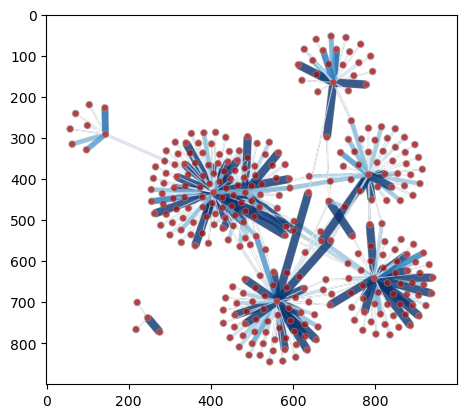

In [3]:


    
    
    
    



plt.imshow(graph_1)


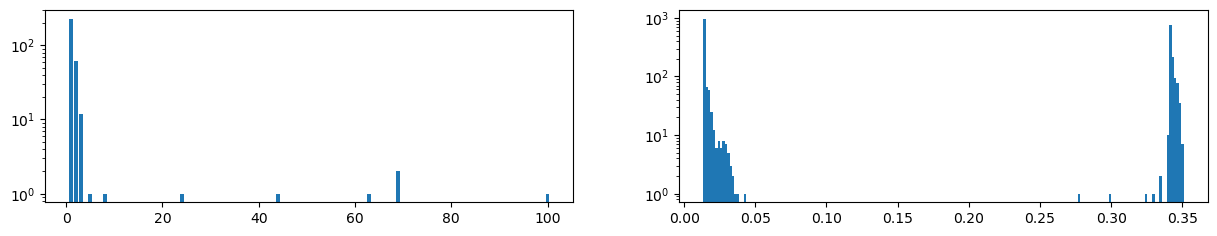

In [30]:
G = nx.gnp_random_graph(100, 0.02, seed=10374196)


def get_degree_distr(G):
    

    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    #dmax = max(degree_sequence)

    #fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    #axgrid = fig.add_gridspec(5, 4)
    degree_counts = np.unique(degree_sequence, return_counts=True)
    return(degree_counts)

fig = plt.figure(figsize=(15,2.5))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1)
degree_counts = get_degree_distr(NX_edge_weights_Non_masked)
ax1.bar(*degree_counts)
ax1.set_yscale('log')


ax2.hist(edge_weights_Non_masked.select_dtypes(float).mean(), bins=200)
ax2.set_yscale('log')

0       0.013527
1       0.344294
2       0.014151
3       0.341779
4       0.013541
          ...   
2396    0.013468
2397    0.013380
2398    0.341450
2399    0.042651
2400    0.343877
Length: 2401, dtype: float32

(0.0, 1.0, 0.0, 1.0)

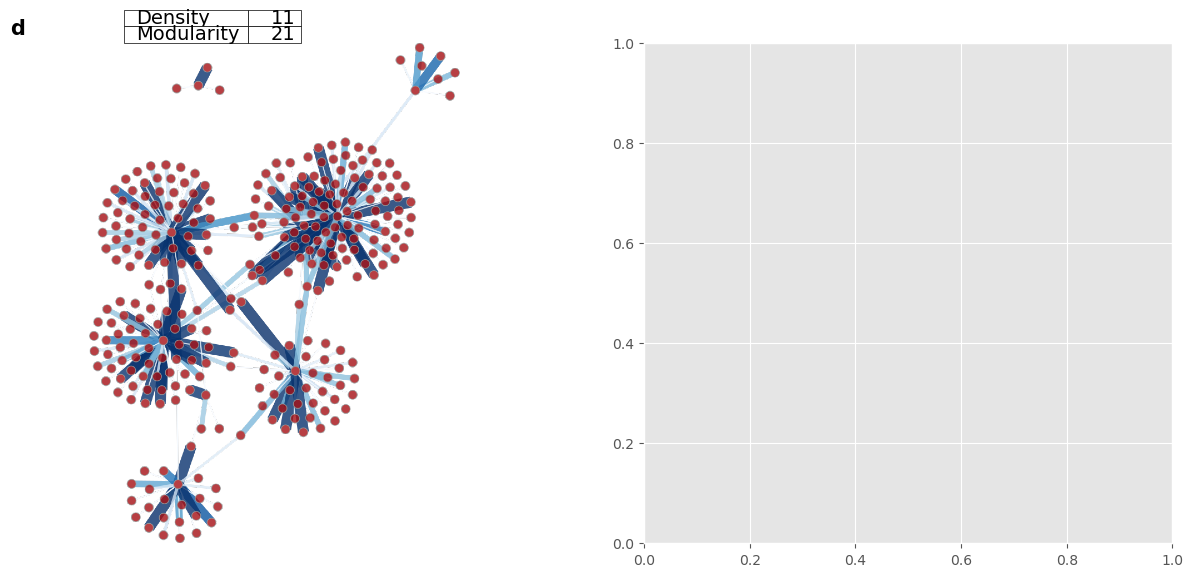

In [32]:
plt.style.use('ggplot')   



fig = plt.figure(figsize=(15,6.5))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1)

def place_image(im, loc=10, ax=None, zoom=1, **kw):
    if ax==None: ax=plt.gca()
    imagebox = OffsetImage(im, zoom=zoom)
    ab       = AnchoredOffsetbox(loc='center', child=imagebox, pad=0., borderpad =0, frameon=False)
    ax.add_artist(ab)
    
place_image(graph_1, loc=1, ax=ax1, pad=0, zoom=0.4)

row_labels=['Density','Modularity']
table_vals=[[11],[21]]
# the rectangle is where I want to place the table
the_table = ax1.table(cellText=table_vals,
                  colWidths = [0.1]*3,
                  rowLabels=row_labels,
                  #colLabels=col_labels,
                  loc='top')
the_table.auto_set_font_size(False)
the_table.set_fontsize(14)

ax1.set_title('d', fontsize = 15,  fontweight ="bold", loc='left')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.axis('off')

(0.7064113929480392, 0.6080317085511889)

In [ ]:

G = NX_edge_weights_Masked

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()


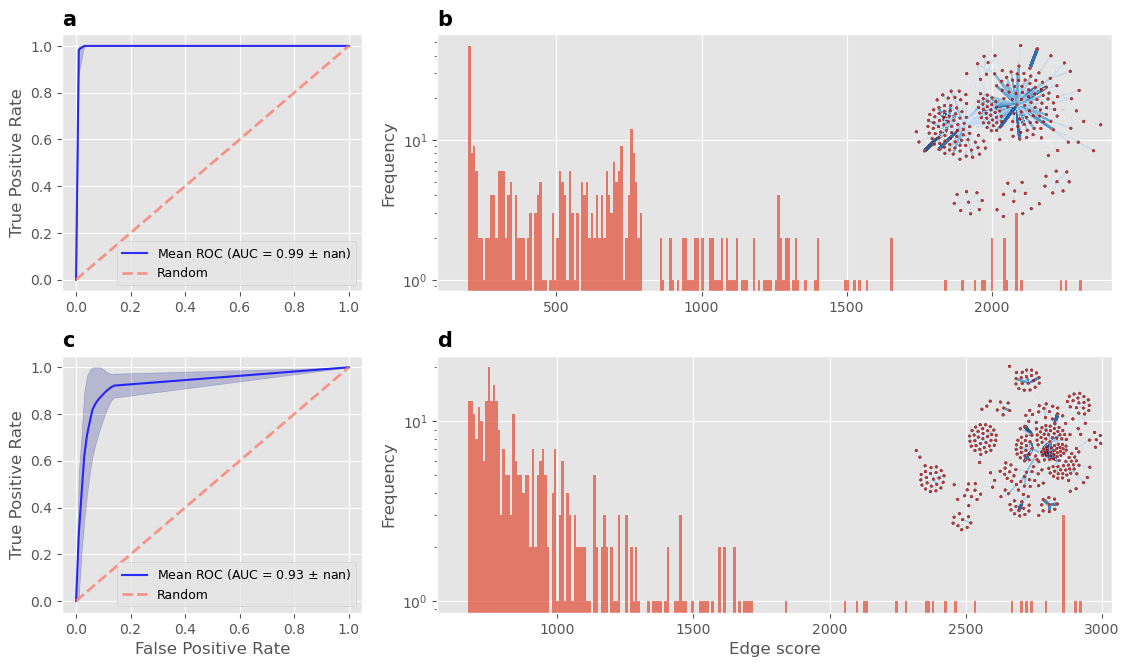

In [84]:
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox



score_array_NON_MASKED =  np.array(
edge_weights_Non_masked.select_dtypes(include=np.number).sum(axis=1))


score_array_MASKED =  np.array(
edge_weights_Masked.select_dtypes(include=np.number).sum(axis=1))

def place_image(im, loc=10, ax=None, zoom=1, **kw):
    if ax==None: ax=plt.gca()
    imagebox = OffsetImage(im, zoom=zoom)
    ab       = AnchoredOffsetbox(loc='upper right', child=imagebox, pad=0., borderpad =0, frameon=False)
    ax.add_artist(ab)



plt.style.use('ggplot')   
fig = plt.figure(figsize=(15,6.5))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=3)
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=1)
ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=.8, top=0.99, wspace=0.25, hspace=0.25)

ax2.hist(score_array_NON_MASKED, log=True, bins = 250,  alpha = 0.7)
place_image(graph_1, loc=1, ax=ax2, pad=0, zoom=0.15)
ax2.set_title('b', fontsize = 15,  fontweight ="bold", loc='left')
ax2.set_ylabel('Frequency')


ax4.hist(score_array_MASKED, log=True, bins = 250,  alpha = 0.7)
place_image(graph_2, loc=1, ax=ax4, pad=0, zoom=0.15)
ax4.set_title('d', fontsize = 15,  fontweight ="bold", loc='left')
ax4.set_ylabel('Frequency')
ax4.set_xlabel('Edge score')





def put_in_subplot(base_fpr, mean_tprs, tprs_lower,
                   tprs_upper, mean_auc, std_auc, AX, xlabel:str='', letter:str=''):
    
    AX.plot(base_fpr, mean_tprs, 'blue', alpha = 0.8, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    AX.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'navy', alpha = 0.2)
    AX.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'salmon', label = 'Random', alpha= 0.8)

    #ax1.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])

    AX.legend(loc="lower right", fontsize=9)
    AX.set_ylabel('True Positive Rate')
    AX.set_xlabel(xlabel)
    AX.set_title(letter, fontsize = 15,  fontweight ="bold", loc='left')

put_in_subplot(base_fpr_2, mean_tprs_2, tprs_lower_2, tprs_upper_2, mean_auc_2, std_auc_2 , ax1, letter = 'a')

put_in_subplot(base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc, ax3, xlabel = 'False Positive Rate', letter = 'c')


plt.savefig("./results/figures/Figure_2.png",
            bbox_inches ="tight",
            pad_inches = 0.01,
            transparent = False)

plt.show()




